# Week 3: Pretrained models

## Basic Convnet Model
Let's train a basic convnet model on the CIFAR-10 dataset first to see its performance. 

In [79]:
import numpy as np
import keras

batch_size = 32 # number of images in each batch
img_size = (32, 32) # 32 x 32 pixel images in input data

# Load 
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    './CIFAR-10-images/train',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical',
    validation_split=0.2, 
    subset='both',
    seed=123)

test_dataset = keras.utils.image_dataset_from_directory(
    './CIFAR-10-images/test',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical')

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.


In [80]:
from keras import Sequential
from keras import layers

model = Sequential([ 
    layers.Input(shape=(32, 32, 3)),
    layers.Rescaling(scale=1./255),
    layers.Conv2D(32, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(10, activation='softmax') ]) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,    
    epochs=10,
    verbose=0)

test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6646 - loss: 1.0131 
Test Loss: 1.0189
Test Accuracy: 0.6688


The basic convnet achieved a test accuracy of 0.6688 with two convolutional layers followed by max-pooling, a fully connected hidden layer, and an output layer. Next, we'll use a pretrained VGG16 model for feature extraction and compare its performance.

## Feature extraction with a pretrained model - VGG16

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(32, 32, 3)
)

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        # Using the conv_base predict method to extract features
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    # Concatenate all features and labels into single arrays
    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features and labels from the datasets
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

## Fully connected top model
The VGG16 model outputs a feature map of shape (1, 1, 512) for each image. We will flatten this feature map and add a fully connected top model and experiment with different hyperparameters to improve the model's performance.

In [87]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model1 = keras.Model(inputs, outputs)
model1.compile(loss="categorical_crossentropy",
               optimizer='rmsprop',
               metrics=["accuracy"])

callbacks = [EarlyStopping(patience=30, restore_best_weights=True, monitor='val_loss')]  

history1 = model1.fit(train_features, train_labels, epochs=200, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=0)

In [88]:
test_loss, test_accuracy = model1.evaluate(test_features, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6701 - loss: 0.9794  
Test Loss: 0.9575
Test Accuracy: 0.6785


## Plotting the training and validation accuracy and loss

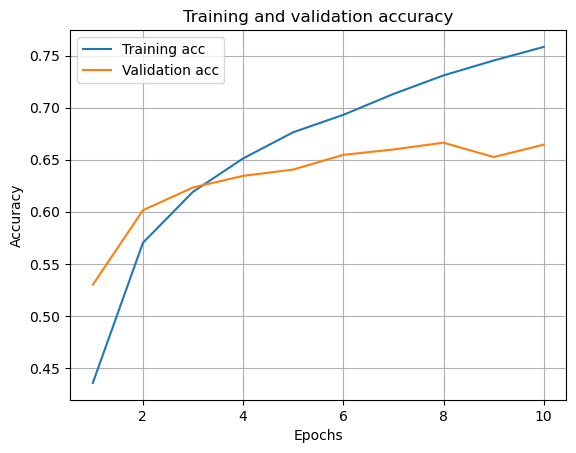

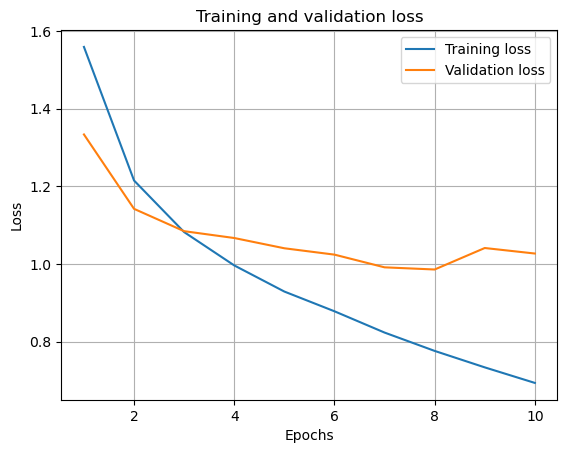

In [85]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

plt.figure()        

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

plt.show()

## Conclusion

Accuracy of both models:
- Basic Convnet: around **0.665**
- VGG16 + FCN: around **0.675**

The pretrained VGG16 model did not significantly outperform the basic convolutional neural network, although a slight improvement in accuracy was achieved through experimentation.

Initially, the fully connected top model consisted of a single hidden Dense layer with 256 units, which reached a test accuracy of **0.62**. By adding additional hidden layers, along with **dropout** and **batch normalization**, I was able to improve the test accuracy to **0.67**.

I experimented with different optimizers, and found that **RMSprop** generally performed better than **Adam** in this context. Increasing the number of hidden layers beyond four did not lead to further improvements. Likewise, using more than 256 units in the first hidden layer did not boost performance.

I also tested **kernel regularization**, but I did not see improvements in accuracy.